In [1]:
import warnings
warnings.filterwarnings("ignore", message="Unable to find acceptable character detection dependency")

In [ ]:
%matplotlib inline


Skipping, found downloaded files in ".\digit-recognizer" (use force=True to force download)
Loading training data from: ./digit-recognizer\train.csv
Loading test data from: ./digit-recognizer\test.csv
Training data shape: (42000, 784)
Training labels shape: (42000,)
Test data shape: (28000, 784)
Splitting data into training and validation sets...
Creating training augmented dataset...
Creating augmented dataset with 10000 samples...
Processing sample 0/10000
Processing sample 1000/10000
Processing sample 2000/10000
Processing sample 3000/10000
Processing sample 4000/10000
Processing sample 5000/10000
Processing sample 6000/10000
Processing sample 7000/10000
Processing sample 8000/10000
Processing sample 9000/10000
Creating validation augmented dataset...
Creating augmented dataset with 2000 samples...
Processing sample 0/2000
Processing sample 1000/2000


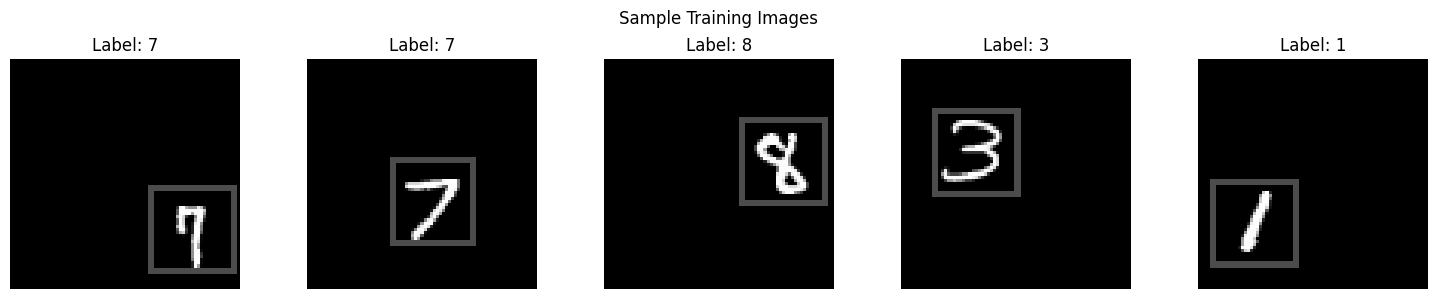

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 73, 73, 16)   160         ['input_4[0][0]']                
                                                                                                  
 average_pooling2d_9 (AveragePo  (None, 36, 36, 16)  0           ['conv2d_9[0][0]']               
 oling2D)                                                                                         
                                                                                                  
 conv2d_10 (Conv2D)             (None, 34, 34, 32)   4640        ['average_pooling2d_9[0][0]

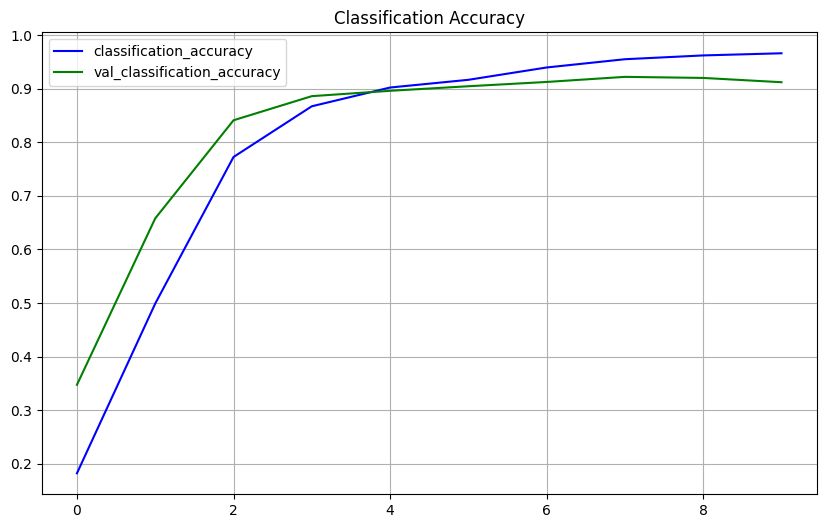

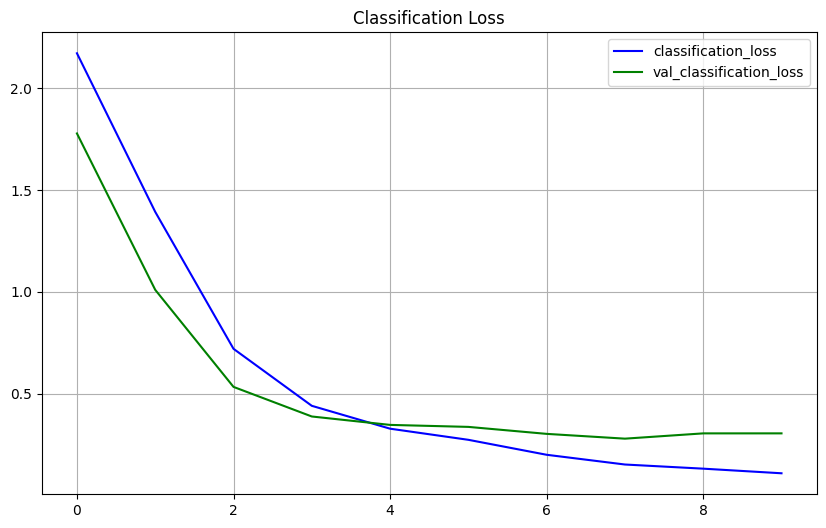

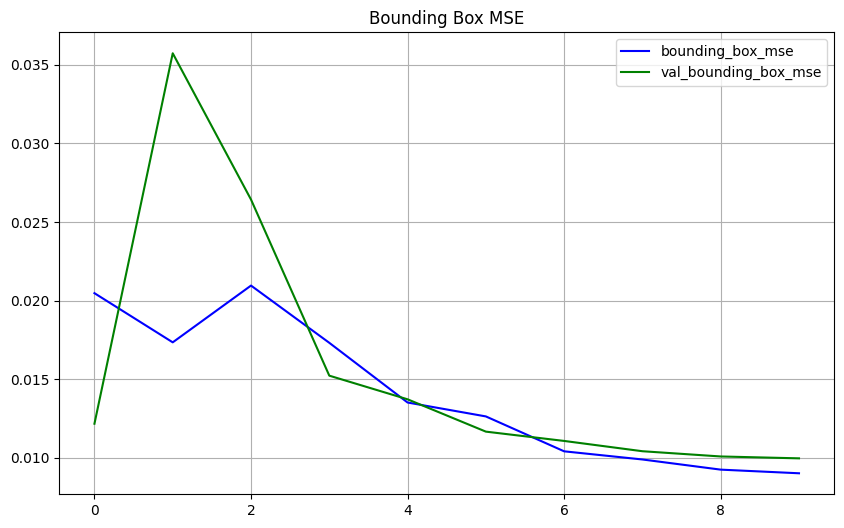

Making predictions...
63/63 [==============================] - 2s 28ms/step


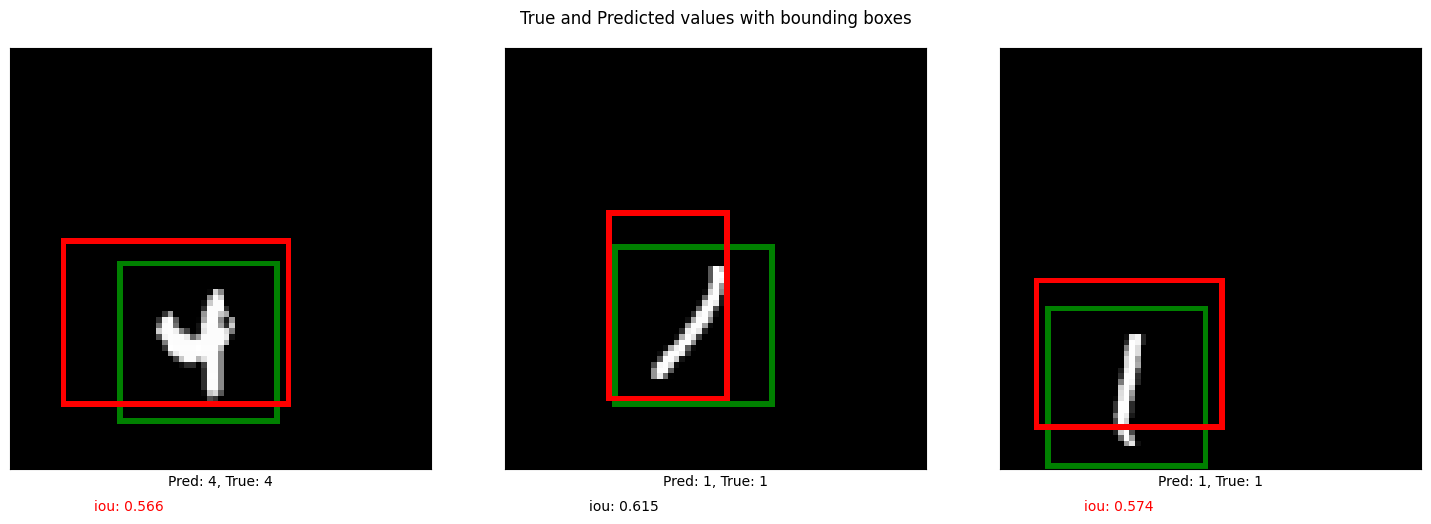

Training completed successfully!


In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from sklearn.model_selection import train_test_split
import opendatasets as od

def download_kaggle_dataset():
    kaggle_dataset_url = 'https://www.kaggle.com/c/digit-recognizer/data'
    
    print("Downloading dataset from Kaggle...")
    od.download(kaggle_dataset_url)
    
    return './digit-recognizer'

def load_mnist_from_csv(data_dir):
    train_path = os.path.join(data_dir, 'train.csv')
    test_path = os.path.join(data_dir, 'test.csv')
    
    print(f"Loading training data from: {train_path}")
    print(f"Loading test data from: {test_path}")
    
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    train_labels = train_df['label'].values
    train_images = train_df.drop('label', axis=1).values
    
    test_labels = None
    test_images = test_df.values
    
    print(f"Training data shape: {train_images.shape}")
    print(f"Training labels shape: {train_labels.shape}")
    print(f"Test data shape: {test_images.shape}")
    
    return train_images, train_labels, test_images, test_labels

data_dir = download_kaggle_dataset()

train_images, train_labels, test_images, _ = load_mnist_from_csv(data_dir)

im_width = 75
im_height = 75
BATCH_SIZE = 64
use_normalized_coordinates = True

def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=1, display_str_list=()):
    image_pil = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new("RGBA", image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
    return np.array(rgbimg)

def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=1, display_str_list=()):
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError("Input must be of size [n,4]")
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i,1], boxes[i,0], boxes[i,3], boxes[i,2], 
                                 color[i], thickness, display_str_list[i])

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color="red", thickness=1, 
                             display_str_list=None, use_normalized_coordinates=True):
    draw = PIL.ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        left, right, top, bottom = (xmin*im_width, xmax*im_width, ymin*im_height, ymax*im_height)
    else:
        left, right, top, bottom = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], 
             width=thickness, fill=color)

def create_augmented_dataset(images, labels, num_samples=None):
    if num_samples is not None:
        images = images[:num_samples]
        labels = labels[:num_samples]
    
    augmented_images = []
    augmented_labels = []
    bounding_boxes = []
    
    print(f"Creating augmented dataset with {len(images)} samples...")
    
    for i in range(len(images)):
        if i % 1000 == 0:
            print(f"Processing sample {i}/{len(images)}")
        
        digit = images[i].reshape(28, 28).astype('float32') / 255.0
        
        xmin = np.random.randint(0, 48)
        ymin = np.random.randint(0, 48)
        
        canvas = np.zeros((75, 75), dtype='float32')
        
        canvas[ymin:ymin+28, xmin:xmin+28] = digit
        
        augmented_images.append(canvas)
        augmented_labels.append(labels[i])
        
        xmin_norm = xmin / 75.0
        ymin_norm = ymin / 75.0
        xmax_norm = (xmin + 28) / 75.0
        ymax_norm = (ymin + 28) / 75.0
        bounding_boxes.append([xmin_norm, ymin_norm, xmax_norm, ymax_norm])
    
    return np.array(augmented_images), np.array(augmented_labels), np.array(bounding_boxes)

print("Splitting data into training and validation sets...")
train_images_split, val_images_split, train_labels_split, val_labels_split = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

print("Creating training augmented dataset...")
train_images_aug, train_labels_aug, train_bboxes = create_augmented_dataset(
    train_images_split, train_labels_split, num_samples=10000
)

print("Creating validation augmented dataset...")
val_images_aug, val_labels_aug, val_bboxes = create_augmented_dataset(
    val_images_split, val_labels_split, num_samples=2000
)

train_labels_onehot = tf.keras.utils.to_categorical(train_labels_aug, 10)
val_labels_onehot = tf.keras.utils.to_categorical(val_labels_aug, 10)

def create_tf_dataset(images, labels_onehot, bboxes, batch_size, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((
        images.reshape(-1, 75, 75, 1),
        (labels_onehot, bboxes)
    ))
    
    if shuffle:
        dataset = dataset.shuffle(1000)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

train_dataset = create_tf_dataset(train_images_aug, train_labels_onehot, train_bboxes, BATCH_SIZE, shuffle=True)
val_dataset = create_tf_dataset(val_images_aug, val_labels_onehot, val_bboxes, BATCH_SIZE)

def display_sample_images(images, labels, bboxes, title, num_samples=5):
    indices = np.random.choice(len(images), num_samples)
    sample_images = images[indices]
    sample_labels = labels[indices]
    sample_bboxes = bboxes[indices]
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    fig.suptitle(title)
    
    for i, ax in enumerate(axes):
        img = (sample_images[i] * 255).astype(np.uint8)
        
        bbox = sample_bboxes[i]
        xmin, ymin, xmax, ymax = bbox
        left = int(xmin * 75)
        right = int(xmax * 75)
        top = int(ymin * 75)
        bottom = int(ymax * 75)
        
        img_pil = PIL.Image.fromarray(img)
        draw = PIL.ImageDraw.Draw(img_pil)
        draw.rectangle([left, top, right, bottom], outline="red", width=2)
        
        ax.imshow(np.array(img_pil), cmap='gray')
        ax.set_title(f'Label: {sample_labels[i]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images(train_images_aug, train_labels_aug, train_bboxes, "Sample Training Images")

def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation="relu", kernel_size=3, input_shape=(75, 75, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, activation="relu", kernel_size=3)(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, activation="relu", kernel_size=3)(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)
    return x

def dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    return x

def classifier(inputs):
    classification_output = tf.keras.layers.Dense(10, activation="softmax", name="classification")(inputs)
    return classification_output

def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(4, name="bounding_box")(inputs)
    return bounding_box_regression_output

def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)
    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)
    model = tf.keras.Model(inputs=inputs, outputs=[classification_output, bounding_box_output])
    return model

model = final_model(tf.keras.layers.Input(shape=(75, 75, 1)))
model.compile(optimizer="adam",
              loss={"classification": "categorical_crossentropy", "bounding_box": "mse"},
              metrics={"classification": "accuracy", "bounding_box": "mse"})

model.summary()

EPOCHS = 10
print("Starting training...")
history = model.fit(train_dataset,
                   epochs=EPOCHS,
                   validation_data=val_dataset,
                   verbose=1)

print("Evaluating model...")
loss, classification_loss, bounding_box_loss, classification_acc, bounding_box_mse = model.evaluate(val_dataset)
print("\n" + "="*50)
print("Validation accuracy:", classification_acc)
print("Bounding box MSE:", bounding_box_mse)
print("="*50)

def plot_metrics(metric_name, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(history.history[metric_name], color="blue", label=metric_name)
    if f"val_{metric_name}" in history.history:
        plt.plot(history.history[f"val_{metric_name}"], color="green", label=f"val_{metric_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics("classification_accuracy", "Classification Accuracy")
plot_metrics("classification_loss", "Classification Loss")
plot_metrics("bounding_box_mse", "Bounding Box MSE")

def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = np.split(pred_box, 4, axis=1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis=1)
    
    smoothing_factor = 1e-10
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)
    
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0) * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)
    return iou

print("Making predictions...")
predictions = model.predict(val_images_aug.reshape(-1, 75, 75, 1), verbose=1)
predicted_labels = np.argmax(predictions[0], axis=1)
predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, val_bboxes)

def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, boxes, iou, title, n=3):
    indexes = np.random.choice(len(predictions), size=n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]
    n_iou = iou[indexes] if len(iou) > 0 else []
    n_pred_bboxes = pred_bboxes[indexes] if len(pred_bboxes) > 0 else []
    n_boxes = boxes[indexes] if len(boxes) > 0 else []
    
    n_digits = (n_digits * 255.0).astype(np.uint8)
    
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    
    for i in range(n):
        ax = fig.add_subplot(1, n, i+1)
        boxes_to_plot = []
        display_strs = []
        
        if len(n_boxes) > i:
            boxes_to_plot.append(n_boxes[i])
            display_strs.append("True")
        
        if len(n_pred_bboxes) > i:
            boxes_to_plot.append(n_pred_bboxes[i])
            display_strs.append("Pred")
        
        img_to_draw = draw_bounding_boxes_on_image_array(
            image=n_digits[i], 
            boxes=np.asarray(boxes_to_plot), 
            color=["green", "red"],
            display_str_list=display_strs
        )
        
        plt.xlabel(f'Pred: {n_predictions[i]}, True: {n_labels[i]}')
        if n_predictions[i] != n_labels[i]:
            ax.xaxis.label.set_color("red")
        
        plt.imshow(img_to_draw, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        if len(n_iou) > i:
            color = "black"
            iou_threshold = 0.6
            if n_iou[i] < iou_threshold:
                color = "red"
            ax.text(0.2, -0.1, f"iou: {n_iou[i][0]:.3f}", color=color, transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()

iou_threshold = 0.6
display_digits_with_boxes(val_images_aug, predicted_labels, val_labels_aug, 
                         predicted_bboxes, val_bboxes, iou, 
                         "True and Predicted values with bounding boxes")

print("Training completed successfully!")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 73, 73, 16)   160         ['input_1[0][0]']                
                                                                                                  
 average_pooling2d (AveragePool  (None, 36, 36, 16)  0           ['conv2d[0][0]']                 
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 (Conv2D)              (None, 34, 34, 32)   4640        ['average_pooling2d[0][0]']  

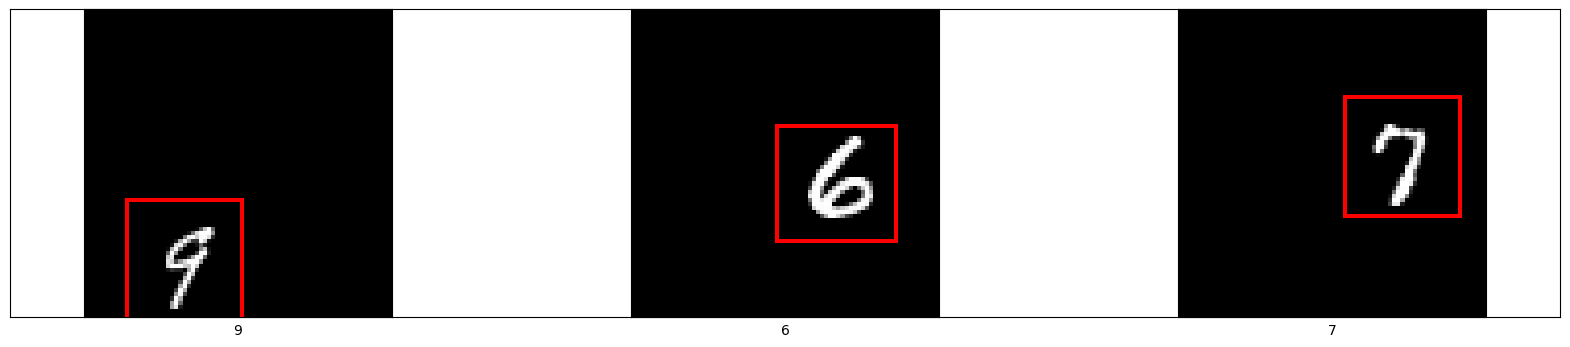

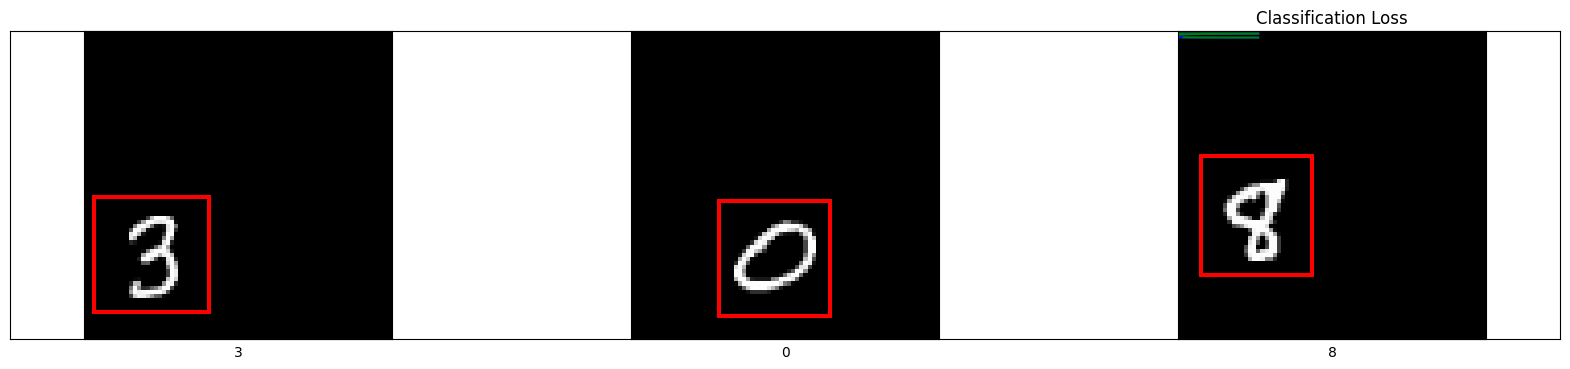

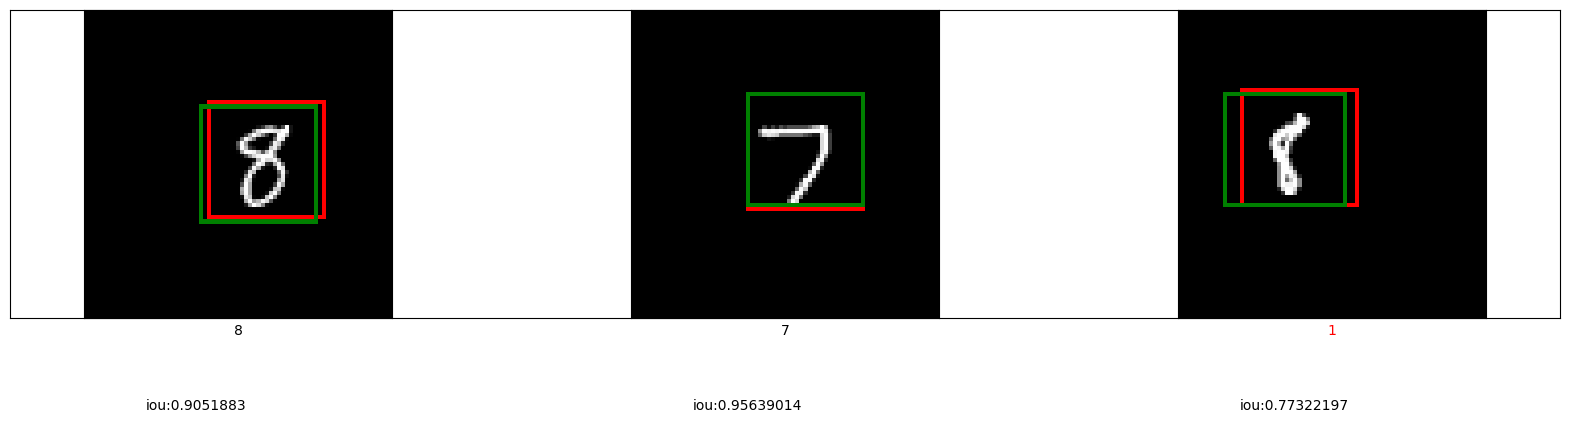

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL.Image,PIL.ImageFont,PIL.ImageDraw
import tensorflow_datasets as tfds
im_width=75
im_height=75
use_normalized_cordinates=True
def draw_bounding_boxes_on_image_array(image,boxes,color=[],thickness=1,display_str_list=()):
    image_pil=PIL.Image.fromarray(image)
    rgbimg=PIL.Image.new("RGBA",image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg,boxes,color,thickness,display_str_list)
    return np.array(rgbimg)
def draw_bounding_boxes_on_image(image,boxes,color=[],thickness=1,display_str_list=()):
    boxes_shape=boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape)!=2 or boxes_shape[1]!=4:
        raise ValueError("Input must be of size [n,4]")
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image,boxes[i,1],boxes[i,0],boxes[i,3],boxes[i,2],color[i],thickness,display_str_list[i])
def draw_bounding_box_on_image(image,ymin,xmin,ymax,xmax,color="red",thickness=1,display_str_list=None,use_normalized_cordinates=True):
    draw=PIL.ImageDraw.Draw(image)
    im_width,im_height=image.size
    if use_normalized_cordinates:
        (left,right,top,bottom)=(xmin*im_width,xmax*im_width,ymin*im_height,ymax*im_height)
    else:
        (left,right,top,bottom)=(xmin,xmax,ymin,ymax)
    draw.line([(left,top),(left,bottom),(right,bottom),(right,top),(left,top)],width=thickness,fill=color)    
def dataset_to_numpy_util(training_dataset,validation_dataset,N):
    batch_train_ds=training_dataset.unbatch().batch(N)
    if tf.executing_eagerly():
        for validation_digits,(validation_labels,validation_boxes)in validation_dataset:
            validation_digits=validation_digits.numpy()
            validation_labels=validation_labels.numpy()
            validation_boxes=validation_boxes.numpy()
            break
        for training_digits,(training_labels,training_boxes) in training_dataset:
            training_digits=training_digits.numpy()
            training_labels=training_labels.numpy()
            training_boxes=training_boxes.numpy()
            break
    validation_labels=np.argmax(validation_labels,axis=1)   
    training_labels=np.argmax(training_labels,axis=1)
    return(training_digits,training_labels,training_boxes,validation_digits,validation_labels,validation_boxes) 
MATPLOTLIB_FONT_DIR=os.path.join(os.path.dirname(plt.__file__),"mpl-data/fonts/ttf")
def create_digits_from_local_fonts(n):
    font_labels=[]
    img=PIL.Image.new("LA",(75*n,75),color=(0,255))
    font1=PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR,"DejaVuSanaMono-Oblique.ttf"),25)
    font2=PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR,"STIXGeneral.ttf"),25)
    d=PIL.ImageDraw.Draw(img)
    for i in range(n):
        font_labels.append(i%10)
        d.text((7+i*75,0 if i<10 else -4),str(i%10),fill=(255,255),font=font1 if i<10 else font2)
    font_digits=np.array(img.getdata(),np.float32)[:,0]/255.0
    font_digits=np.reshape(np.stack(np.split(np.reshape(font_digits,[75,75*n]),n,axis=1),axis=0)[n,75*75])    
    return font_digits,font_labels
def display_digits_with_boxes(digits,predictions,labels,pred_bboxes,boxes,iou,title):
    n=3
    indexes=np.random.choice(len(predictions),size=n)
    n_digits=digits[indexes]
    n_predictions=predictions[indexes]
    n_labels=labels[indexes]
    n_iou=[]
    if len(iou)>0:
        n_iou=iou[indexes]
    if len(pred_bboxes)>0:
        n_pred_bboxes=pred_bboxes[indexes]
    if len(boxes)>0:
        n_boxes=boxes[indexes]    
    n_digits=n_digits*255.0
    n_digits=n_digits.reshape(n,75,75)
    fig=plt.figure(figsize=(20,4))
    plt.xticks([])    
    plt.yticks([])
    for i in range(n):
        ax=fig.add_subplot(1,n,i+1)
        boxes_to_plot=[]
        if (len(pred_bboxes)>i):
            boxes_to_plot.append(n_pred_bboxes[i])
        if (len(boxes)>i):
            boxes_to_plot.append(n_boxes[i])
        img_to_draw=draw_bounding_boxes_on_image_array(image=n_digits[i],boxes=np.asarray(boxes_to_plot),color=["red","green"],display_str_list=["True","Pred"])    
        plt.xlabel(n_predictions[i])
        plt.xticks([])
        plt.yticks([])
        if n_predictions[i]!=n_labels[i]:
            ax.xaxis.label.set_color("red")
        plt.imshow(img_to_draw)
        if len(iou)>i:
            color="black"
            if (n_iou[i][0]<iou_threshold):
                color="red" 
            ax.text(0.2,-0.3,"iou:%s"%(n_iou[i][0]),color=color,transform=ax.transAxes)
def plot_metrics(metric_name,title):
    plt.title(title)
    plt.plot(history.history[metric_name],color="blue",label=metric_name) 
    plt.plot(history.history["val_"+metric_name],color="green",label="val_"+metric_name) 
strategy=tf.distribute.get_strategy()
strategy.num_replicas_in_sync
BATCH_SIZE=64*strategy.num_replicas_in_sync            
def read_image_tfds(image,label):
    xmin=tf.random.uniform((),0,48,dtype=tf.int32)                 
    ymin=tf.random.uniform((),0,48,dtype=tf.int32)
    image=tf.reshape(image,(28,28,1)) 
    image=tf.image.pad_to_bounding_box(image,ymin,xmin,im_width,im_height)
    image=tf.cast(image,tf.float32)  /255.0
    xmin=tf.cast(xmin,tf.float32)
    ymin=tf.cast(ymin,tf.float32)
    xmax=(xmin+28)/75
    ymax=(ymin+28)/75
    xmin=xmin/75
    ymin=ymin/75
    return image,(tf.one_hot(label,10),[xmin,ymin,xmax,ymax])
def get_training_dataset():
    with strategy.scope():
        dataset=tfds.load("mnist",split="train",as_supervised=True,try_gcs=True)
        dataset=dataset.map(read_image_tfds,num_parallel_calls=16)
        dataset=dataset.shuffle(5000,reshuffle_each_iteration=True)
        dataset=dataset.repeat()
        dataset=dataset.batch(BATCH_SIZE,drop_remainder=True)          
        dataset=dataset.prefetch(-1)
    return dataset
def get_validation_dataset():
    with strategy.scope():
        dataset=tfds.load("mnist",split="train",as_supervised=True,try_gcs=True)
        dataset=dataset.map(read_image_tfds,num_parallel_calls=16)
        dataset=dataset.batch(10000,drop_remainder=True)
        dataset=dataset.repeat()
    return dataset
with strategy.scope():
    training_dataset=get_training_dataset()
    validation_dataset=get_validation_dataset()
(training_digits,training_labels,training_bboxes,validation_digits,validation_labels,validation_bboxes)=dataset_to_numpy_util(training_dataset,validation_dataset,10)
display_digits_with_boxes(training_digits,training_labels,training_labels,np.array([]),training_bboxes,np.array([]),"Training digits and labels") 
display_digits_with_boxes(validation_digits,validation_labels,validation_labels,np.array([]),validation_bboxes,np.array([]),"Validation digits and labels") 

def feature_extractor(inputs):
    x=tf.keras.layers.Conv2D(16,activation="relu",kernel_size=3,input_shape=(75,75,1))(inputs)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    x=tf.keras.layers.Conv2D(32,activation="relu",kernel_size=3)(x)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    x=tf.keras.layers.Conv2D(64,activation="relu",kernel_size=3)(x)
    x=tf.keras.layers.AveragePooling2D((2,2))(x)
    return x
def dense_layers(inputs):
    x=tf.keras.layers.Flatten()(inputs)
    x=tf.keras.layers.Dense(128,activation="relu")(x)
    return x
def classifier(inputs):
    classification_output=tf.keras.layers.Dense(10,activation="softmax",name="classification")(inputs)
    return classification_output
def bounding_box_regression(inputs):
    bounding_box_regression_output=tf.keras.layers.Dense(4,name="bounding_box")(inputs)
    return bounding_box_regression_output
def final_model(inputs):
    feature_cnn=feature_extractor(inputs)
    dense_output=dense_layers(feature_cnn)
    classification_output=classifier(dense_output)
    bounding_box_output=bounding_box_regression(dense_output)
    model=tf.keras.Model(inputs=inputs,outputs=[classification_output,bounding_box_output])
    return model
def define_and_compile_model(inputs):
    model=final_model(inputs)
    model.compile(optimizer="adam",loss={"classification":"categorical_crossentropy","bounding_box":"mse"},metrics={"classification":"accuracy","bounding_box":"mse"})
    return model
with strategy.scope():
    inputs=tf.keras.layers.Input(shape=(75,75,1,))
    model=define_and_compile_model(inputs)
model.summary()

EPOCHS=20
steps_per_epoch=60000 //BATCH_SIZE
history=model.fit(training_dataset,steps_per_epoch=steps_per_epoch,validation_data=validation_dataset,validation_steps=1,epochs=EPOCHS)
loss,classification_loss,bounding_box_loss,classification_acc,bounding_box_mse=model.evaluate(validation_dataset,steps=1)
print("\n----------------------------------\n")
print("validation accuracy:",classification_acc)
print("\n-----------------------------------\n")
plot_metrics("bounding_box_mse","Bounding Box MSE")
plot_metrics("classification_accuracy","Classification Accuracy")
plot_metrics("classification_loss","Classification Loss")

def intersection_over_union(pred_box,true_box):
    xmin_pred,ymin_pred,xmax_pred,ymax_pred=np.split(pred_box,4,axis=1)
    xmin_true,ymin_true,xmax_true,ymax_true=np.split(true_box,4,axis=1)
    smoothing_factor=1e-10
    xmin_overlap=np.maximum(xmin_pred,xmin_true)
    xmax_overlap=np.minimum(xmax_pred,xmax_true)
    ymin_overlap=np.maximum(ymin_pred,ymin_true)
    ymax_overlap=np.minimum(ymax_pred,ymax_true)
    pred_box_area=(xmax_pred-xmin_pred)*(ymax_pred-ymin_pred)
    true_box_area=(xmax_true-xmin_true)*(ymax_true-ymin_true)
    overlap_area=np.maximum((xmax_overlap-xmin_overlap),0)*np.maximum((ymax_overlap-ymin_overlap),0)
    union_area=(pred_box_area+true_box_area)-overlap_area
    iou=(overlap_area+smoothing_factor)/(union_area+smoothing_factor)
    return iou
prediction=model.predict(validation_digits,batch_size=64)
predicted_labels=np.argmax(prediction[0],axis=1)
prediction_bboxes=prediction[1]
iou=intersection_over_union(prediction_bboxes,validation_bboxes)
iou_threshold=0.6
display_digits_with_boxes(validation_digits,predicted_labels,validation_labels,prediction_bboxes,validation_bboxes,iou,"True and Pred values")
plt.show()
